In [1]:
import time, array, random, copy, math

import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean

from itertools import chain
from operator import attrgetter, itemgetter

In [2]:
from deap import algorithms, base, benchmarks, tools, creator
import deap.benchmarks.tools as bt

In [3]:
#import platypus

In [4]:
import wfg

In [5]:
import os, pickle, gzip

In [6]:
wfg_l = 10

In [7]:
objective_sizes = (3,) # 6, 9, 12)

In [8]:
problem_instance_creators = {'WFG1': wfg.create_instance_wfg1} #, 'WFG2': wfg.create_instance_wfg2,
                            #'WFG3': wfg.create_instance_wfg3, 'WFG4': wfg.create_instance_wfg4,
                            #'WFG5': wfg.create_instance_wfg5, 'WFG6': wfg.create_instance_wfg6,
                            #'WFG7': wfg.create_instance_wfg7, 'WFG8': wfg.create_instance_wfg8,
                            #'WFG9': wfg.create_instance_wfg9}

In [9]:
selections = ('Crowding distance', 'Random', 'Random keeping extremes', 'Euclidean distance',
              'Euclidean dist. keeping extremes', 'Hypervolume-based')

In [10]:
def define_individual_class(num_obj, is_maximization=False):
    'Returns the class to be used for the individual(s)'
    if is_maximization:
        fit_name = 'FitnessMax' + str(num_obj)
        weights = weights = (1.0,) * num_obj
    else:
        fit_name = 'FitnessMin' + str(num_obj)
        weights = weights = (-1.0,) * num_obj

    try:
        attrgetter(fit_name)(creator)
    except AttributeError:
        creator.create(fit_name, base.Fitness, weights=weights)

    try:
        attrgetter('IndividualObj' + str(num_obj))(creator)
    except AttributeError:
        creator.create('IndividualObj' + str(num_obj), list,
                       typecode='d', fitness=attrgetter(fit_name)(creator))
    return attrgetter('IndividualObj' + str(num_obj))(creator)

In [11]:
def load_experiment_result(experiment_name, results_folder, prob_name, num_objs, sel_name):
    define_individual_class(num_objs)
    
    sel_trans = sel_name.replace(' ', '_').lower()
    
    file_name = experiment_name + '--' + prob_name + '--' + str(num_objs) + '--' + sel_trans + '.pik.gz'
    
    logbooks = pickle.load(gzip.open(results_folder+file_name, 'rb'))
    return logbooks

# Computing hypervolume

In [12]:
def compute_reference_point(logbooks, num_objs, epsilon=0.5):
    all_pops = [ind.fitness.values for method in logbooks for logbook in logbooks[method] for pop in logbook.select('pop') for ind in pop  ]
    return np.max(all_pops, axis =0) + epsilon

In [13]:
def compute_hypervolumes(logbooks, reference):
    '''Returns a dictionary that binds a method name with a list. 
    Each element of the list is a list of hypervolume values 
    that correspond to one `logbook` (run).'''
    max_hyp = -np.inf
    min_hyp = np.inf
    
    hypervolumes = {}
    for method in logbooks:
        hypervolumes[method] = []
        for logbook in logbooks[method]:
            hypers =[]
            for pop in logbook.select('pop'):
                filt = tools.sortNondominated(pop, len(pop), first_front_only=True)[0]
                hypers.append(bt.hypervolume(filt, reference))
            max_hyp = max((max(hypers),max_hyp))
            min_hyp = min((min(hypers),min_hyp))
            hypervolumes[method].append(hypers)
    return hypervolumes, min_hyp, max_hyp

In [14]:
def full_process_hypervolumes(logbooks, num_objs):
    reference = compute_reference_point(logbooks, num_objs)
    # print('Using reference point: ', reference)
    return compute_hypervolumes(logbooks, reference)

# Plotting results

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
import seaborn as sns
sns.set(style="white", palette="Set2")

In [17]:
labels = ['Crowding distance', 'Random', 'Random with extremes', 
          'Euclidean distance', 'Euclidean distance with extremes',
          'Hypervolume-based']

In [18]:
markers = ['o', '^', 'v', 's', 'D', '8']

In [19]:
linestyles = ['-', '--', '-.', ':']

In [20]:
def plot_compact(hypervolumes, hyp_lims=None, title=None, ylabel='Hypervolume'):
    plt.figure(figsize=(7,3))
    pal = sns.color_palette("Dark2", len(hypervolumes))

    for idx, method in enumerate(sorted(hypervolumes)):
        means = np.mean(hypervolumes[method], axis=0)
        sns.tsplot(hypervolumes[method], err_style='ci_band', ci=95, n_boot=100, 
                       interpolate=False, color=pal[idx], marker=None, err_kws={'alpha':0.1})
        plt.plot(means, color=pal[idx], label=method, markevery=10,
                 marker=markers[idx], linestyle=linestyles[idx%len(linestyles)],linewidth=1,
                 markeredgewidth=1, markeredgecolor=pal[idx], markerfacecolor='None', alpha=0.92)
        
    plt.legend()
    plt.title(title)
    plt.grid(True, zorder=5)
    plt.tight_layout()
    plt.ylabel(ylabel)
    plt.xlabel('Iterations')

In [23]:
experiment_name = 'first'

In [24]:
results_folder = os.getcwd() + os.sep + 'results'+ os.sep

In [25]:
results = {}
for prob_name in problem_instance_creators:
    for num_objs in objective_sizes:
        logbooks={}
        for sel_name in selections:
            print('Loading:', prob_name, num_objs, sel_name)
            logbooks[sel_name] = load_experiment_result(experiment_name, results_folder, 
                                                        prob_name, num_objs, sel_name)
        results[(prob_name, num_objs)] = logbooks

Loading: WFG1 3 Crowding distance
Loading: WFG1 3 Random
Loading: WFG1 3 Random keeping extremes
Loading: WFG1 3 Euclidean distance
Loading: WFG1 3 Euclidean dist. keeping extremes
Loading: WFG1 3 Hypervolume-based


In [ ]:
results_hyp = {}
for prob_name in problem_instance_creators:
    for num_objs in objective_sizes:
        print('Processing:', prob_name, num_objs, sel_name)
        logbooks = results[(prob_name, num_objs)]
        reference = compute_reference_point(logbooks, num_objs)
        hypervolumes , _, _ = compute_hypervolumes(logbooks, reference)
        results_hyp[(prob_name, num_objs)] = hypervolumes

In [ ]:
for prob_name in problem_instance_creators:
    for num_objs in objective_sizes:
        print('Processing:', prob_name, num_objs, sel_name)
        plot_compact(results_hyp[(prob_name, num_objs)], 
                     title=prob_name + '; $m=' + str(num_objs) + '$.')

In [26]:
hypervolumes , _, _ = compute_hypervolumes(logbooks, reference)

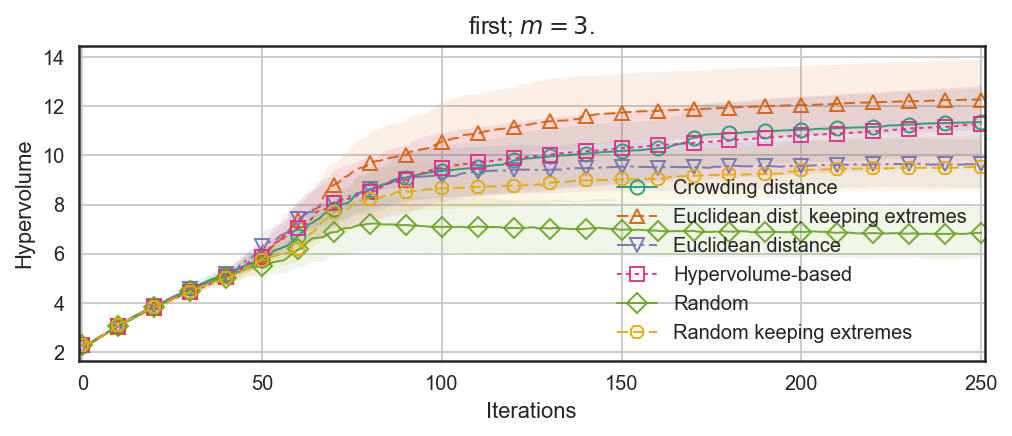

In [61]:
plot_compact(hypervolumes, title=experiment_name+ '; $m=3$.')